<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/UNet_Model_BraTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation with U-NET


In [1]:
# Import libraries
import tarfile
import re
import imageio as iio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import scipy.ndimage
import textwrap

## Download the imaging dataset


In [20]:
!gdown https://drive.google.com/uc?id=194mSmKU5qNOkJ5GNocTwwvThbwWLwBEG

# Assuming the downloaded file is a ZIP file and its name is 'downloaded_data.zip'
import zipfile
with zipfile.ZipFile('BraTS_total.zip', 'r') as zip_ref:
    zip_ref.extractall()

Downloading...
From: https://drive.google.com/uc?id=194mSmKU5qNOkJ5GNocTwwvThbwWLwBEG
To: /content/BraTS_total.zip
100% 55.7M/55.7M [00:02<00:00, 23.8MB/s]


# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [25]:
from glob import glob

#Test set folder
!mkdir brats_test
!mkdir brats_test/images
!mkdir brats_test/masks

test_patients_list = ['BraTS-GLI-t1c/BraTS-GLI-00000-000-t1c.nii.gz*', 'BraTS-GLI-t1c/BraTS-GLI-00005-000-t1c.nii.gz*']
for patient in test_patients_list:
    test_set = glob(patient)
    for test_img_path in test_set:
        test_seg_path = test_img_path.replace('t1c', 'seg')
        !mv $test_img_path brats_test/images
        !mv $test_seg_path brats_test/masks


#Train set folder
!mkdir brats_train
!mkdir brats_train/images
!mkdir brats_train/masks

train_set = glob('BraTS-GLI-t1c/*.png')
for train_img_path in train_set:
    train_seg_path = train_img_path.replace('t1c', 'seg')
    !mv $train_img_path brats_train/images
    !mv $train_seg_path brats_train/masks




In [5]:
def normalise_intensity(image, ROI_thres=0.1):
    """
    The function identifies the ROI in the image by applying a percentile-based threshold,
    then standardizes the pixel values in this region by subtracting the mean and dividing
    by the standard deviation.

    Args:
        image (np.array): Input image as a NumPy array.
        ROI_thres (float): Percentile threshold for defining the ROI (default is 0.1).

    Returns:
        np.array: Image array with normalized intensity in the ROI.
    """
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def sort_key(filename):
    """ Extracts the numerical part from the filename and returns it for sorting. """
    numbers = re.findall(r'\d+', filename)
    return int(numbers[-1]) if numbers else filename

import os
import random
import numpy as np
import imageio.v2 as iio

class BrainImageSet():
    def __init__(self, image_path, label_path, modality, deploy=False, train_ratio=0.75):
        self.image_path = image_path
        self.label_path = label_path
        self.deploy = deploy
        self.images = []
        self.labels = []
        self.image_names = []  # Store image names
        self.label_names = []  # Store label names
        self.patient_indices = {}  # Store indices of slices for each patient

        image_names = sorted(os.listdir(image_path), key=sort_key)
        for image_name in image_names:
            patient_id = image_name.split('-')[2]  # Extract patient ID from filename
            idx = len(self.images)

            full_image_path = os.path.join(image_path, image_name)
            image = iio.imread(full_image_path)
            self.images.append(image)
            self.image_names.append(image_name)

            if not deploy:
                label_name = image_name.replace(modality, 'seg')
                full_label_path = os.path.join(label_path, label_name)
                label = iio.imread(full_label_path)
                self.labels.append(label)
                self.label_names.append(label_name)

            if patient_id not in self.patient_indices:
                self.patient_indices[patient_id] = []
            self.patient_indices[patient_id].append(idx)

        self.train_indices, self.validation_indices = self._split_patients(train_ratio)

    def _split_patients(self, train_ratio):
        patient_ids = list(self.patient_indices.keys())
        random.shuffle(patient_ids)
        split_idx = int(len(patient_ids) * train_ratio)
        train_patients = patient_ids[:split_idx]
        validation_patients = patient_ids[split_idx:]

        train_indices = [idx for patient in train_patients for idx in self.patient_indices[patient]]
        validation_indices = [idx for patient in validation_patients for idx in self.patient_indices[patient]]

        return train_indices, validation_indices

    def map_labels(self, label):
        """
        Maps label values to the correct class indices.
        """
        label_map = {0: 0, 85: 1, 170: 2, 255: 3}
        mapped_label = label.copy()
        for k, v in label_map.items():
            mapped_label[label == k] = v
        return mapped_label


    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        image = normalise_intensity(self.images[idx])

        # Get its label map
        label = self.labels[idx]
        label = self.map_labels(label)

        return image, label


    def get_random_batch(self, batch_size, indices):
        images_batch, labels_batch = [], []

        idx_array = list(range(len(self.images)))
        batch_idx = random.sample(indices, batch_size)
        for i in range(batch_size):
            image, label = self.__getitem__(batch_idx[i])
            images_batch.append(image)
            labels_batch.append(label)

        images_batch, labels_batch = np.array(images_batch), np.array(labels_batch)
        images_batch = np.expand_dims(images_batch, 1)
        return images_batch, labels_batch

    def visualize_normalized_slices(self, num_slices=5):
        # Choose random images to visualize
        num_images = len(self.images)
        random_indices = np.random.choice(num_images, num_slices, replace=False)

        for idx in random_indices:
            image = self.images[idx]
            image_norm = normalise_intensity(image)  # Apply intensity normalization
            label = self.labels[idx]

            # Assuming each image has a corresponding filename or identifier
            image_name = self.image_names[idx]  # or however you store/access the filenames
            label_name = self.label_names[idx]  # similarly for labels, if available

            # Wrap text to avoid overlap
            wrapped_image_name = textwrap.fill(image_name, width=30)  # Adjust width as needed
            wrapped_label_name = textwrap.fill(label_name, width=30)  # Adjust width as needed

            # Visualize the normalized image and its label
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figure size as needed
            axes[0].imshow(image_norm, cmap='gray')
            axes[0].set_title(f'Normalized Slice:\n{wrapped_image_name}')  # Include the image name
            axes[1].imshow(label, cmap='gray')
            axes[1].set_title(f'Label:\n{wrapped_label_name}')  # Include the label name
            plt.tight_layout()  # Adjust layout
            plt.show()

    def get_filenames(self, indices):
        """
        Retrieves the filenames of images and their corresponding labels for given indices.

        Args:
            indices (list): A list of indices for which filenames are required.

        Returns:
            list: A list of tuples, each containing the image name and label name.
        """
        filenames = []
        for idx in indices:
            image_name = self.image_names[idx]
            label_name = self.label_names[idx]
            filenames.append((image_name, label_name))
        return filenames

example = BrainImageSet("BraTS-GLI-t1c", "BraTS-GLI-seg", "t1c")
train_indices, test_indices = example._split_patients(0.8)

# Get filenames for the train and test batches
train_filenames = example.get_filenames(train_indices)
test_filenames = example.get_filenames(test_indices)
print('train_filenames:',len(train_filenames), 'test_filenames:' ,len(test_filenames))

train_filenames: 1395 test_filenames: 310


In [11]:
test_filenames

[('BraTS-GLI-00005-000-t1c.nii.gz_slice0.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice0.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice1.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice1.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice2.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice2.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice3.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice3.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice4.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice4.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice5.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice5.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice6.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice6.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice7.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice7.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice8.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice8.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice9.png',
  'BraTS-GLI-00005-000-seg.nii.gz_slice9.png'),
 ('BraTS-GLI-00005-000-t1c.nii.gz_slice10.png',
  

In [7]:
# Get the total number of images (assuming all modalities have the same number of images)
num_images = len(example.images)

# Generate a list of indices
indices = list(range(num_images))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)  # 20% for testing

train_images, train_labels = example.get_random_batch(16, train_indices)
train_images, train_labels = torch.from_numpy(train_images), torch.from_numpy(train_labels)
train_images, train_labels = train_images.to("cpu", dtype=torch.float32), train_labels.to("cpu", dtype=torch.long)

unique_labels = torch.unique(train_labels)
print("Unique label values in train_labels:", unique_labels)
print(test_indices)

Unique label values in train_labels: tensor([0, 1, 2, 3])
[1046, 745, 785, 367, 1029, 1648, 259, 1509, 514, 1229, 23, 570, 115, 914, 352, 599, 620, 810, 237, 1078, 1507, 530, 1569, 940, 429, 185, 78, 316, 1005, 351, 1197, 1452, 1435, 239, 271, 631, 1001, 1323, 619, 1433, 707, 70, 188, 585, 453, 1096, 1118, 300, 629, 1405, 576, 1604, 787, 1682, 420, 411, 275, 49, 1211, 394, 173, 462, 1671, 518, 1566, 1145, 135, 923, 818, 69, 1189, 1543, 1631, 706, 324, 917, 864, 65, 1461, 1567, 764, 1700, 939, 1176, 680, 1412, 29, 1233, 759, 344, 1305, 611, 30, 408, 598, 1105, 289, 1488, 1231, 1477, 820, 99, 332, 943, 1265, 1165, 1281, 590, 1116, 405, 993, 660, 529, 1516, 1290, 534, 203, 486, 32, 415, 339, 1483, 522, 557, 778, 845, 374, 1084, 583, 433, 1505, 44, 811, 527, 535, 817, 59, 212, 724, 353, 1544, 1375, 1591, 720, 1489, 950, 426, 774, 398, 350, 1296, 210, 1089, 1026, 1285, 1314, 1237, 1358, 1374, 614, 1027, 124, 1178, 711, 1202, 694, 1661, 439, 1315, 162, 1464, 806, 381, 1146, 1450, 966, 261, 7

# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    # Convolution layer, a ReLU activation to add non-linearity, and Batch Normalisation
    # Bias is set as false, as Batch Normalisation would remove the bias
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  # U-Net Model involves an encoder, a bottleneck and decoder section
  def __init__(self):
    super().__init__()
    # Encoder with 4 blocks of Double_Convolution layers
    # Includes 4 sets of max pooling operations with kernel 2x2 and stride 2 for downsampling
    self.down_1 = nn.Sequential(
        conv_block(1, 16),
        conv_block(16, 16),
    )
    self.down_2 = nn.Sequential(
        conv_block(16, 32, 2),
        conv_block(32, 32),
    )
    self.down_3 = nn.Sequential(
        conv_block(32, 64, 2),
        conv_block(64, 64),
    )
    # Bottleneck
    # Includes a Double Convolution layer followed by upsampling with ConvTranspose2d
    self.bottle = nn.Sequential(
        conv_block(64, 128, 2),
        conv_block(128, 128),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    )

    # Decoder
    # Concatinating with skip connections causes feature channels to double
    # Double_Convolution and ConvTranspose2d each causes feature channels to halve
    self.up_1 = nn.Sequential(
        conv_block(128, 64),
        conv_block(64, 64),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    self.up_2 = nn.Sequential(
        conv_block(64, 32),
        conv_block(32, 32),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    # Final Output Layer
    self.out = nn.Sequential(
        conv_block(32, 16),
        conv_block(16, 16),
        nn.Conv2d(16, 4, kernel_size=1, padding=0)
    )

  def forward(self, x):
      # Use the convolutional operators defined above to build the U-net
      # Encoder
      x1 = self.down_1(x)
      x2 = self.down_2(x1)
      x3 = self.down_3(x2)

      x4 = self.bottle(x3)

      # Decoder
      ### Insert your code ###
      x5 = torch.cat((x4, x3), dim=1)
      x6 = self.up_1(x5)
      x7 = torch.cat((x6, x2), dim=1)
      x8 = self.up_2(x7)
      x9 = torch.cat((x8, x1), dim=1)
      x10 = self.out(x9)
      return x10


# Train the segmentation model

In [ ]:
# CUDA device
device = torch.device('cuda')
print('Device: {0}'.format(device))

# Build the model
model = UNet()
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
loss_fn = nn.CrossEntropyLoss(ignore_index=128)

# Create an instance of BrainImageSet
brain_dataset = BrainImageSet("BraTS-GLI-t1c", "BraTS-GLI-seg", "t1c")

# Train the model
epochs = 10000
train_batch_size = 25
eval_batch_size = 25
start = time.time()
for epoch in range(epochs):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Fetch a batch of training data and transfer it to the device
    train_images, train_labels = brain_dataset.get_random_batch(train_batch_size, train_indices)
    train_images, train_labels = torch.from_numpy(train_images), torch.from_numpy(train_labels)
    train_images, train_labels = train_images.to(device, dtype=torch.float32), train_labels.to(device, dtype=torch.long)
    # Perform a forward pass through the model
    model_labels = model(train_images)

    # Note that optimizer.zero_grad() is equivalent to net.zero_grad() if it optimises all the net parameters.
    optimizer.zero_grad()

    optimizer.zero_grad() # Clear previous gradients

    unique_labels = torch.unique(train_labels)

    loss = loss_fn(model_labels, train_labels) # Compute loss


    loss.backward() # Carry out backpropagation and calculate gradients
    optimizer.step() # Update model parameters

    # Evaluate
    if epoch % 2000 == 0:
        print('--- Epoch {0}: Training loss = {1:.4f}, {2:.4f} s ---'.format(epoch, loss.item(), time.time() - start_iter))
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            test_images, test_labels = brain_dataset.get_random_batch(eval_batch_size, test_indices)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

            pred_labels = model(test_images)

            test_loss = loss_fn(pred_labels, test_labels)
            print('--- Epoch {0}: Test loss = {1:.4f} ---\n'.format(epoch, test_loss.item()))

    # Save the model
    if epoch % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(epoch)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
--- Epoch 0: Training loss = 1.3389, 1.8974 s ---
--- Epoch 0: Test loss = 1.4155 ---

--- Epoch 2000: Training loss = 0.0171, 0.3337 s ---
--- Epoch 2000: Test loss = 0.0157 ---

--- Epoch 4000: Training loss = 0.0104, 0.3325 s ---
--- Epoch 4000: Test loss = 0.0146 ---

--- Epoch 6000: Training loss = 0.0036, 0.3335 s ---
--- Epoch 6000: Test loss = 0.0100 ---

--- Epoch 8000: Training loss = 0.0017, 0.3337 s ---
--- Epoch 8000: Test loss = 0.0020 ---

Training took 2022.810s in total.


In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 13.2 MB/s eta 0:00:00


# Visualise the segmentation results

Number of training MRIs: 1364
Number of testing/validation MRIs: 341
Image 0: Class-wise Dice = 0.9984027743339539, Overall Dice = 0.9984027743339539
Image 1: Class-wise Dice = 0.9829339981079102, Overall Dice = 0.9829339981079102
Image 2: Class-wise Dice = 1.0, Overall Dice = 1.0
Image 3: Class-wise Dice = 0.9998090267181396, Overall Dice = 0.9998090267181396
Image 4: Class-wise Dice = 0.9997048377990723, Overall Dice = 0.9997048377990723
Average Class-wise Dice: 0.996170163154602
Average Overall Dice: 0.996170163154602


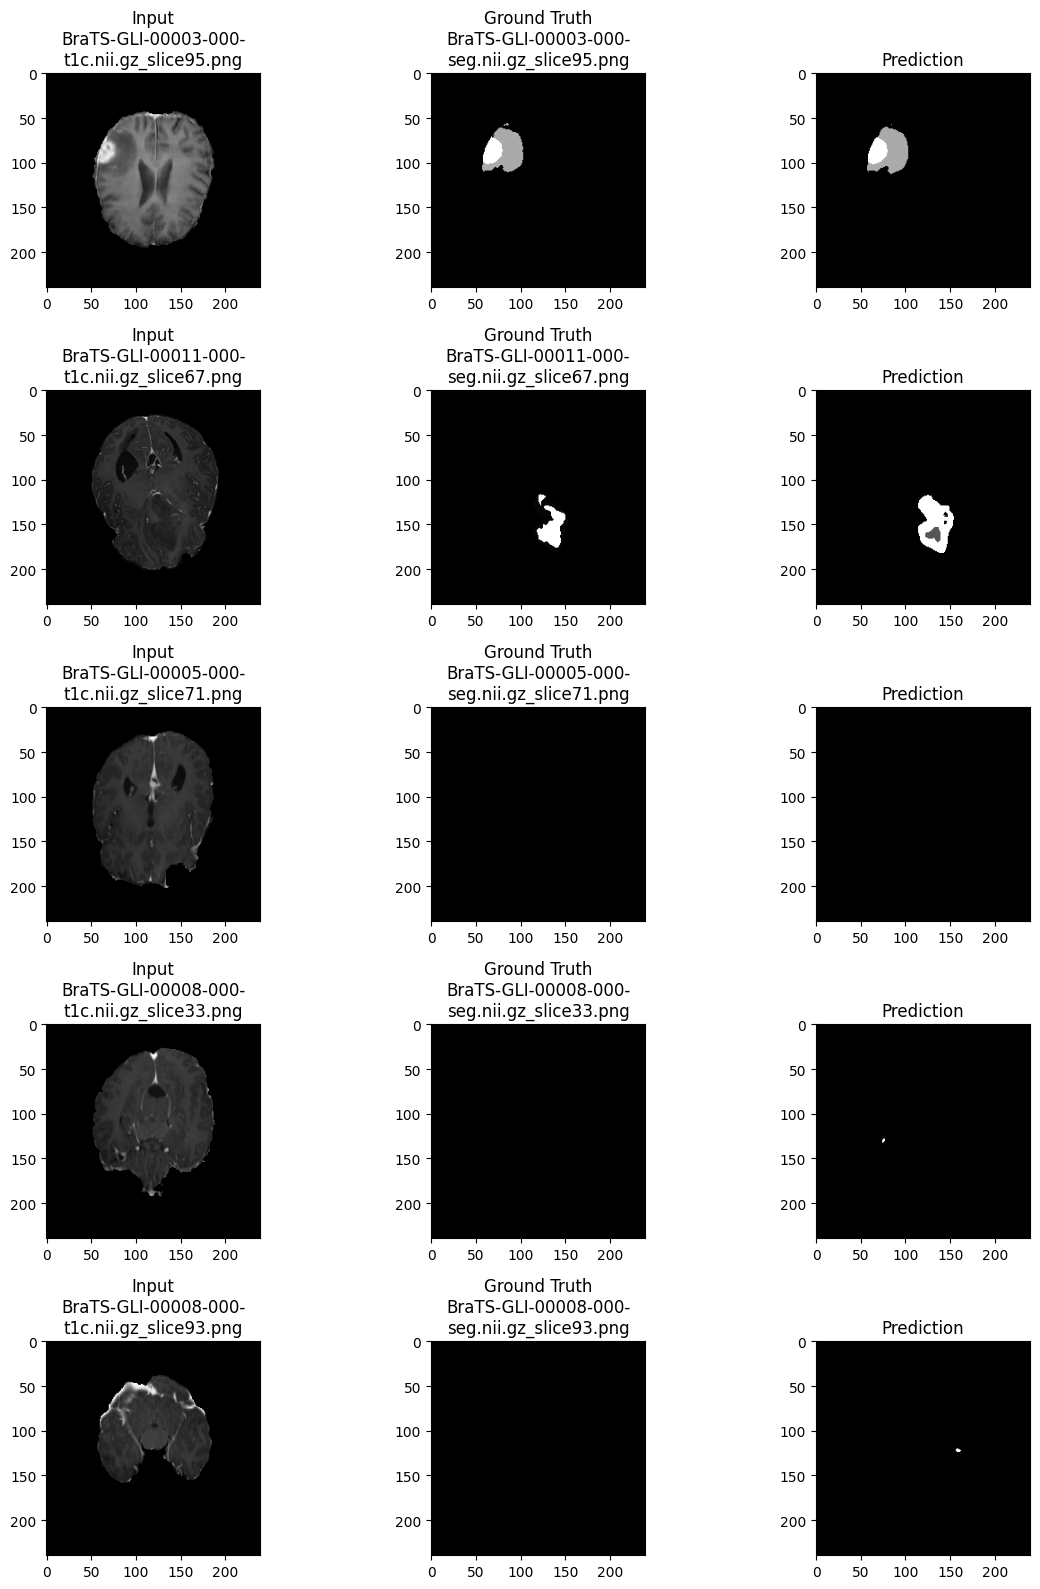

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchmetrics import Dice
import numpy as np
from sklearn.model_selection import train_test_split
import textwrap

# Dataset statistics
num_train_mris = len(train_indices)
num_test_mris = len(test_indices)
print(f"Number of training MRIs: {num_train_mris}")
print(f"Number of testing/validation MRIs: {num_test_mris}")

# Get a random batch of 5 test images and labels
eval_batch_size = 5
test_images, test_labels = brain_dataset.get_random_batch(eval_batch_size, test_indices)
test_images = torch.from_numpy(test_images).to(device, dtype=torch.float32)
test_labels = torch.from_numpy(test_labels).to(device, dtype=torch.long)

# Determine the number of classes dynamically
max_label = max(torch.max(label).item() for label in test_labels)
num_classes = max_label + 1

# Initialize Dice metrics
dice_metric_classwise = Dice(num_classes=num_classes).to(device)
dice_metric_global = Dice(num_classes=num_classes, average='micro').to(device)

# Set the model to evaluation mode
model.eval()

# Forward pass to get logits
logits = model(test_images)
prob = F.softmax(logits, dim=1)
seg = torch.argmax(prob, dim=1)

# Visualization and metric calculation
fig, axs = plt.subplots(eval_batch_size, 3, figsize=(12, 16))
class_wise_dice_scores = []
overall_dice_scores = []

for i in range(eval_batch_size):
    # Get filenames and wrap them
    image_name = brain_dataset.image_names[test_indices[i]]
    label_name = brain_dataset.label_names[test_indices[i]]
    wrapped_image_name = textwrap.fill(image_name, width=30)
    wrapped_label_name = textwrap.fill(label_name, width=30)

    # Visualizations
    axs[i, 0].imshow(test_images[i, 0].cpu().numpy(), cmap='gray')
    axs[i, 0].set_title(f'Input\n{wrapped_image_name}')
    axs[i, 1].imshow(test_labels[i].cpu().numpy(), cmap='gray')
    axs[i, 1].set_title(f'Ground Truth\n{wrapped_label_name}')
    axs[i, 2].imshow(seg[i].cpu().numpy(), cmap='gray')
    axs[i, 2].set_title('Prediction')

    # Dice scores
    class_wise_dice = dice_metric_classwise(seg[i].unsqueeze(0).to(device), test_labels[i].unsqueeze(0).to(device))
    overall_dice = dice_metric_global(seg[i].unsqueeze(0).to(device), test_labels[i].unsqueeze(0).to(device))

    class_wise_dice_scores.append(class_wise_dice)
    overall_dice_scores.append(overall_dice)

    print(f"Image {i}: Class-wise Dice = {class_wise_dice}, Overall Dice = {overall_dice}")

# Calculate and display averages
avg_class_wise_dice = torch.stack(class_wise_dice_scores).mean()
avg_overall_dice = torch.stack(overall_dice_scores).mean()
print(f"Average Class-wise Dice: {avg_class_wise_dice}")
print(f"Average Overall Dice: {avg_overall_dice}")

plt.tight_layout()
plt.show()
